In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader , Dataset
from torchvision import transforms , models

from torchvision.utils import make_grid

if torch.cuda.is_available():
    torch.backends.cudnn.detetministic = True

from torchvision.datasets import ImageFolder

import glob
from torchvision import datasets
from tqdm import tqdm
import timm

#streamlitで実行用のライブラリ
import streamlit as st
import PIL.Image

ModuleNotFoundError: No module named 'altair.vegalite.v4'

In [31]:
train_cat = "./dataset/train/cat"
train_dog = "./dataset/train/dog"

# 各フォルダ下の画像のパスを取得
train_cat_files = glob.glob(train_cat + "/*.jpg")
train_dog_files = glob.glob(train_dog + "/*.jpg")

# 各フォルダ内の画像の枚数を確認
print("[train] : cat", len(train_cat_files), "枚")
print("[train] : dog", len(train_dog_files), "枚")
print()

# 実際にパスを出力してみる
print(train_cat_files)


[train] : cat 911 枚
[train] : dog 912 枚

['./dataset/train/cat\\cat.4001.jpg', './dataset/train/cat\\cat.4002.jpg', './dataset/train/cat\\cat.4003.jpg', './dataset/train/cat\\cat.4004.jpg', './dataset/train/cat\\cat.4005.jpg', './dataset/train/cat\\cat.4006.jpg', './dataset/train/cat\\cat.4007.jpg', './dataset/train/cat\\cat.4008.jpg', './dataset/train/cat\\cat.4009.jpg', './dataset/train/cat\\cat.4010.jpg', './dataset/train/cat\\cat.4011.jpg', './dataset/train/cat\\cat.4012.jpg', './dataset/train/cat\\cat.4013.jpg', './dataset/train/cat\\cat.4014.jpg', './dataset/train/cat\\cat.4015.jpg', './dataset/train/cat\\cat.4016.jpg', './dataset/train/cat\\cat.4017.jpg', './dataset/train/cat\\cat.4018.jpg', './dataset/train/cat\\cat.4019.jpg', './dataset/train/cat\\cat.4020.jpg', './dataset/train/cat\\cat.4021.jpg', './dataset/train/cat\\cat.4022.jpg', './dataset/train/cat\\cat.4023.jpg', './dataset/train/cat\\cat.4024.jpg', './dataset/train/cat\\cat.4025.jpg', './dataset/train/cat\\cat.4026.jp

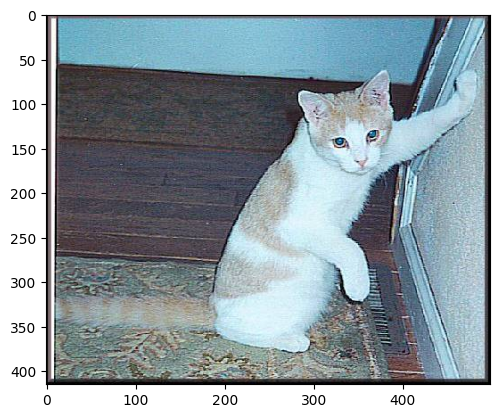

In [ ]:
# 最初の画像をPILで開いて表示（参考：https://teratail.com/questions/98626）
img = PIL.Image.open(train_cat_files[0])
plt.imshow(img)
plt.show()

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("./dataset/train",transform=train_transform)
test_dataset = datasets.ImageFolder("./dataset/test",transform=test_transform)

train_loader = DataLoader(train_dataset,batch_size=128,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)



In [25]:
def train_epoch(model,dataloader,citerion,optimizer,device):
    train_loss , train_acc = 0,0

    model.train()
    for images,labels in tqdm(dataloader):
        images , labels = images.to(device) , labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss=criterion(outputs,labels)
        train_loss += loss.item()*images.size(0)
        acc = (outputs.max(1)[1] == labels).sum()
        train_acc += acc.item()

        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(dataloader.dataset)
    avg_train_acc = train_acc / len(dataloader.dataset)
    return avg_train_loss , avg_train_acc

def test_epoch(model,dataloader,citerion,device):
    test_loss , test_acc = 0,0
    model.eval()
    with torch.no_grad():

        for images,labels in tqdm(dataloader):
            images , labels = images.to(device) , labels.to(device)
            outputs = model(images)
            loss=criterion(outputs,labels)
            test_loss += loss.item()*images.size(0)
            acc = (outputs.max(1)[1] == labels).sum()
            test_acc += acc.item()
    avg_test_loss = test_loss / len(dataloader.dataset)
    avg_test_acc = test_acc / len(dataloader.dataset)
    return avg_test_loss , avg_test_acc

In [5]:
num_classes = len(train_dataset.classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = timm.create_model("resnet18",pretrained=True,num_classes=num_classes)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [6]:
criterion = nn.CrossEntropyLoss()
lr = 0.0001
optimizer = optim.AdamW(model.parameters(),lr=lr)
num_epochs = 30

In [ ]:
train_loss_list , train_acc_list ,test_loss_list,test_acc_list = [],[],[],[]

for epoch in range(num_epochs):
    train_loss , train_acc = train_epoch(model,train_loader,criterion,optimizer,device)
    test_loss , test_acc = test_epoch(model,test_loader,criterion,device)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    print(f"Epoch:{epoch+1},train_loss:{train_loss:.4f},train_acc:{train_acc:.4f},test_loss:{test_loss:.4f},test_acc:{test_acc:.4f}")

100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


Epoch:1,train_loss:0.6423,train_acc:0.7164,test_loss:0.5942,test_acc:0.8400


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


Epoch:2,train_loss:0.5326,train_acc:0.8941,test_loss:0.4946,test_acc:0.9400


100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


Epoch:3,train_loss:0.4315,train_acc:0.9314,test_loss:0.3798,test_acc:0.9500


100%|██████████| 7/7 [00:15<00:00,  2.26s/it]


Epoch:4,train_loss:0.3350,train_acc:0.9512,test_loss:0.2914,test_acc:0.9650


100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


Epoch:5,train_loss:0.2555,train_acc:0.9665,test_loss:0.2177,test_acc:0.9700


100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


Epoch:6,train_loss:0.1934,train_acc:0.9764,test_loss:0.1661,test_acc:0.9750


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


Epoch:7,train_loss:0.1468,train_acc:0.9813,test_loss:0.1283,test_acc:0.9700


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Epoch:8,train_loss:0.1121,train_acc:0.9830,test_loss:0.1073,test_acc:0.9750


100%|██████████| 7/7 [00:13<00:00,  2.00s/it]


Epoch:9,train_loss:0.0907,train_acc:0.9885,test_loss:0.0945,test_acc:0.9700


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


Epoch:10,train_loss:0.0730,train_acc:0.9896,test_loss:0.0841,test_acc:0.9750


100%|██████████| 7/7 [00:15<00:00,  2.26s/it]


Epoch:11,train_loss:0.0560,train_acc:0.9907,test_loss:0.0737,test_acc:0.9800


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Epoch:12,train_loss:0.0489,train_acc:0.9934,test_loss:0.0672,test_acc:0.9750


100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


Epoch:13,train_loss:0.0410,train_acc:0.9940,test_loss:0.0630,test_acc:0.9700


100%|██████████| 7/7 [00:16<00:00,  2.35s/it]


Epoch:14,train_loss:0.0345,train_acc:0.9956,test_loss:0.0619,test_acc:0.9750


100%|██████████| 7/7 [00:15<00:00,  2.25s/it]


Epoch:15,train_loss:0.0305,train_acc:0.9956,test_loss:0.0610,test_acc:0.9800


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Epoch:16,train_loss:0.0244,train_acc:0.9978,test_loss:0.0552,test_acc:0.9750


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Epoch:17,train_loss:0.0216,train_acc:0.9967,test_loss:0.0571,test_acc:0.9750


100%|██████████| 7/7 [00:16<00:00,  2.31s/it]


Epoch:18,train_loss:0.0177,train_acc:0.9978,test_loss:0.0552,test_acc:0.9750


  0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
model = timm.create_model("resnet18",pretrained=False,num_classes=num_classes)
model.load_state_dict(torch.load(f"cat_dog_model.pth" ,map_location=torch.device('cpu')))
#model.to(device)

<All keys matched successfully>

In [13]:
def predict(model,dataloader,device):
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for images,labels in tqdm(dataloader):
            images , labels = images.to(device) , labels.to(device)
            outputs=model(images)
            acc = (outputs.max(1)[1] == labels).sum()
            test_acc += acc.item()
    avg_test_acc = test_acc / len(dataloader.dataset)
    return avg_test_acc

In [14]:
test_acc = predict(model,test_loader,device)
print("テスト用データに対する精度（ACC):",test_acc*100,"%")

100%|██████████| 7/7 [00:10<00:00,  1.51s/it]

テスト用データに対する精度（ACC): 99.0 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

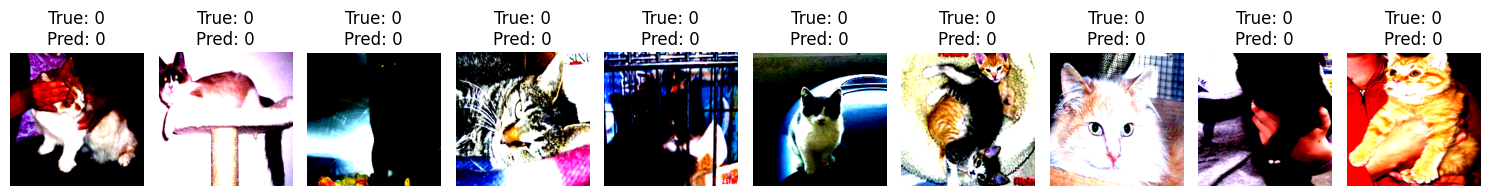

In [18]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# 5枚だけ取り出して表示
model.eval()
images_shown = 0
plt.figure(figsize=(15,3))

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.max(1)[1]  # 予測ラベル

        for i in range(len(images)):
            if images_shown >= 10:
                break

            img = images[i].cpu().permute(1,2,0)  # CHW → HWC に変換
            label = labels[i].cpu().item()
            pred = preds[i].cpu().item()

            plt.subplot(1, 10, images_shown+1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"True: {label}\nPred: {pred}")

            images_shown += 1

        if images_shown >= 10:
            break

plt.tight_layout()
plt.show()


In [ ]:
st.title("犬猫画像分類デモアプリ")

uploaded_file = st.file_uploader("犬か猫の画像をアップロードしてください",type=["jpg","jpeg","png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image,caption="アップロードされた画像",use_column_width=True)

    input_tensor = test_transform(image).unsqueeze(0)

    with st.spinner("予測中..."):
        with torch.no_grad():
            outputs = model(images)
            preds = outputs.max(1)[1]  # 予測ラベル

    st.markdown(f"### 予測結果: {'猫' if preds.item() == 0 else '犬'}")